### **1. Importación de librerías**

In [36]:
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Se importa las librerías necesarias:

* tensorflow: Principal librería usada para construir y entrenar la CNN.
* Path de pathlib: Sirve para manejar rutas de archivos y directorios de manera flexible.
* Sequential, Conv2D, y MaxPooling2D de tensorflow.keras.layers: Componentes específicos para construir una red CNN secuencial.

### **2. Obtención del directorio de trabajo actual y análisis exploratorio de datos**

In [37]:
current_directory = Path(os.getcwd())

In [38]:
emotions = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Se obtiene el directorio de trabajo actual y lo guarda en current_directory. La función print imprime este directorio para confirmar que el script está corriendo en la ruta correcta, lo cual es útil para organizar rutas de archivos en sistemas operativos diferentes.

Cantidad de imágenes en el conjunto de entrenamiento:
{'angry': 3995, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}

Cantidad de imágenes en el conjunto de prueba:
{'angry': 958, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


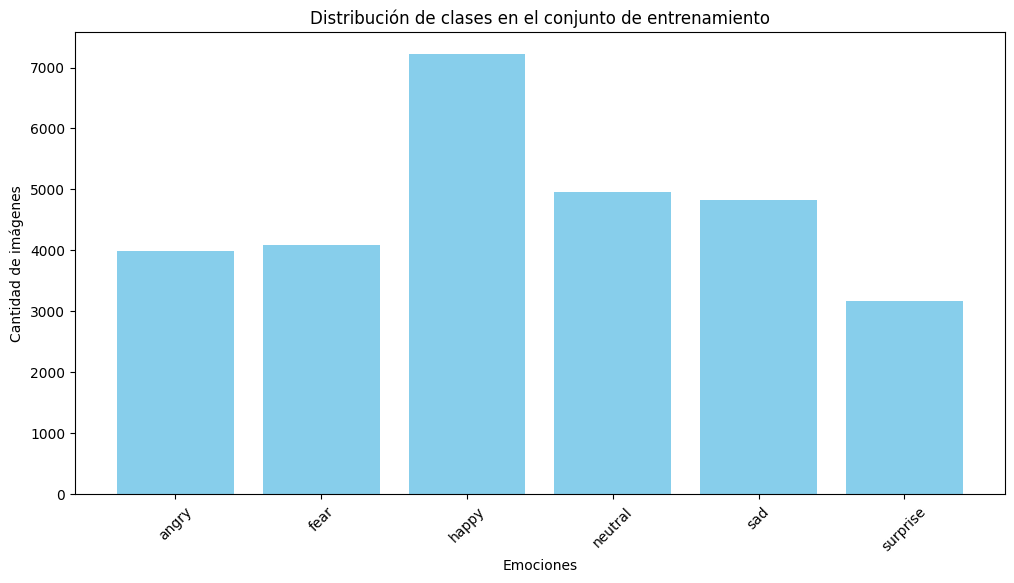

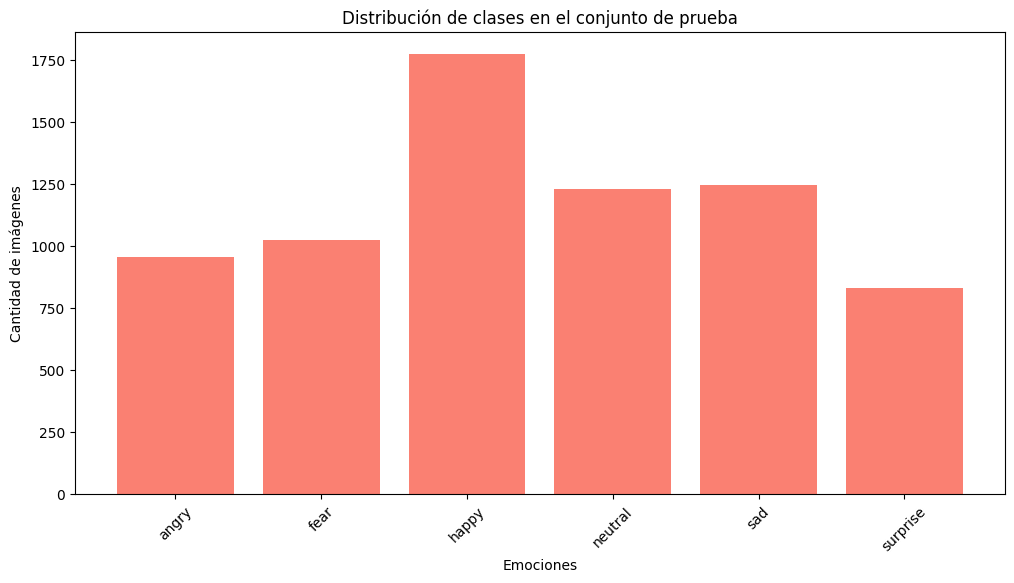

In [39]:
# Contar las imágenes en cada subdirectorio de train y test
train_dir = current_directory / 'data/train'
test_dir = current_directory / 'data/test'

def count_images_in_subdirs(directory):
    class_counts = {}
    for subdir in os.listdir(directory):
        subdir_path = directory / subdir
        if os.path.isdir(subdir_path):
            class_counts[subdir] = len(os.listdir(subdir_path))
    return class_counts

train_counts = count_images_in_subdirs(train_dir)
test_counts = count_images_in_subdirs(test_dir)

print("Cantidad de imágenes en el conjunto de entrenamiento:")
print(train_counts)
print("\nCantidad de imágenes en el conjunto de prueba:")
print(test_counts)

# Visualizar la distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(12, 6))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Emociones')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.show()

# Visualizar la distribución de clases en el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.bar(test_counts.keys(), test_counts.values(), color='salmon')
plt.title('Distribución de clases en el conjunto de prueba')
plt.xlabel('Emociones')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.show()

In [40]:
# Calcular el total de imágenes por categoría
train_counts = {emotion: len(os.listdir(f'{current_directory}/data/train/{emotion}')) for emotion in emotions}
test_counts = {emotion: len(os.listdir(f'{current_directory}/data/test/{emotion}')) for emotion in emotions}

# Calcular el porcentaje de imágenes por categoría respecto al total de cada categoría
percentages = {}
for emotion in emotions:
    total_images = train_counts[emotion] + test_counts.get(emotion, 0)
    train_percentage = (train_counts[emotion] / total_images) * 100 if total_images > 0 else 0
    test_percentage = (test_counts.get(emotion, 0) / total_images) * 100 if total_images > 0 else 0
    
    percentages[emotion] = {
        'total': f"{total_images} (100%)",
        'train': f"{train_counts[emotion]} ({train_percentage:.2f}%)",
        'test': f"{test_counts.get(emotion, 0)} ({test_percentage:.2f}%)"
    }

# Imprimir resultados
print("\nPorcentajes de imágenes por categoría:")
for emotion, data in percentages.items():
    print(f"{emotion.capitalize()}: Total {data['total']}, Train {data['train']}, Test {data['test']}")



Porcentajes de imágenes por categoría:
Angry: Total 4953 (100%), Train 3995 (80.66%), Test 958 (19.34%)
Fear: Total 5121 (100%), Train 4097 (80.00%), Test 1024 (20.00%)
Happy: Total 8989 (100%), Train 7215 (80.26%), Test 1774 (19.74%)
Neutral: Total 6198 (100%), Train 4965 (80.11%), Test 1233 (19.89%)
Sad: Total 6077 (100%), Train 4830 (79.48%), Test 1247 (20.52%)
Surprise: Total 4002 (100%), Train 3171 (79.24%), Test 831 (20.76%)


### **3. Generador de datos de entrenamiento**

In [41]:
training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training_gen = training_data_gen.flow_from_directory(directory=f'{current_directory}/data/train', target_size=(48, 48), color_mode='grayscale', batch_size=32, class_mode='categorical')

Found 28273 images belonging to 6 classes.


Se crea un generador de datos para el conjunto de entrenamiento:

* ImageDataGenerator(rescale=1./255): Normaliza los valores de los píxeles de las imágenes entre 0 y 1 (originalmente están entre 0 y 255).
* flow_from_directory: Carga las imágenes desde el directorio /data/train, con las siguientes configuraciones:
    * target_size=(48, 48): Redimensiona las imágenes a 48x48 píxeles.
    * color_mode='grayscale': Carga las imágenes en escala de grises (1 canal).
    * batch_size=32: Genera los datos en lotes de 32 imágenes.
    * class_mode='categorical': Usa la clasificación categórica para múltiples categorías de emociones.

### **4. Generador de datos de prueba**

In [42]:
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = test_data_gen.flow_from_directory(directory=f'{current_directory}/data/test', target_size=(48, 48), color_mode='grayscale', batch_size=32, class_mode='categorical')

Found 7067 images belonging to 6 classes.


Similar al anterior, pero se configura para el conjunto de prueba en /data/test. Permite evaluar el modelo en datos no vistos, garantizando que el modelo generaliza bien.

### **5. Definición del modelo**

In [43]:
model = tf.keras.Sequential()

Se crea una instancia Sequential, una arquitectura lineal de capas para la CNN. También se define una lista emotions que contiene las categorías de emociones (etiquetas de salida), utilizada más adelante para determinar el tamaño de la capa de salida.

### **6. Capas de la CNN**

In [44]:
# Capa de entrada
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Capas adicionales para mayor profundidad
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Aplanar la salida de las capas convolucionales
model.add(tf.keras.layers.Flatten())

# Capa densa con Dropout para prevenir el sobreajuste
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Dropout para evitar sobreajuste
model.add(tf.keras.layers.Dense(len(emotions), activation='softmax'))

c:\Users\karlo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Capa de entrada:
* Conv2D: Esta es una capa convolucional que aplica un filtro (kernel) a las imágenes de entrada. En este caso, se están utilizando 32 filtros de tamaño 3x3.
* activation='relu': La función de activación ReLU (Rectified Linear Unit) se utiliza para introducir no linealidades en el modelo. Esta función activa solo las neuronas que tienen un valor positivo, ayudando a mitigar el problema del desvanecimiento del gradiente.
* input_shape=(48, 48, 1): Define la forma de la entrada. Las imágenes de entrada tienen un tamaño de 48x48 píxeles y 1 canal (en este caso, imágenes en escala de grises).
* MaxPooling2D: Esta capa reduce la dimensionalidad de la salida de la capa convolucional anterior. Aquí, se está utilizando un tamaño de ventana de 2x2, lo que significa que se toma el valor máximo de cada bloque de 2x2 píxeles en la imagen, lo que ayuda a retener la información más importante y a reducir el tamaño de las características (features).

Capas adicionales para mayor profundidad:
* Conv2D(64, (3, 3)): Se agrega una segunda capa convolucional con 64 filtros.
* MaxPooling2D((2, 2)): De nuevo, se aplica el max pooling para reducir la dimensionalidad.
* Conv2D(128, (3, 3)): Una tercera capa convolucional con 128 filtros. A medida que avanzamos en la red, se suelen incrementar el número de filtros para capturar características más complejas y de alto nivel.
* MaxPooling2D((2, 2)): Otro max pooling para seguir reduciendo la dimensionalidad.

Aplanar la salidad de las capas convolucionales
* Flatten: Esta capa convierte la salida multidimensional de las capas convolucionales en un vector unidimensional. Esto es necesario porque las capas densas (fully connected) que seguirán requieren entradas en forma de vectores.

Capa densa con Dropout para prevenir el sobreajuste
* Dense(128): Esta es una capa densa (fully connected) que conecta todas las neuronas de la capa anterior con 128 neuronas. La activación ReLU se utiliza aquí también para introducir no linealidades.
* Dropout(0.5): Esta capa de dropout se utiliza para reducir el sobreajuste (overfitting) durante el entrenamiento. Durante el entrenamiento, se "apagará" aleatoriamente el 50% de las neuronas en esta capa, lo que ayuda a prevenir que el modelo dependa demasiado de cualquier neurona en particular. Esto fomenta que el modelo aprenda características más robustas y generales.

### **9. Compilación del modelo**

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Se compila el modelo con:

* optimizer='adam': Optimizador Adam para ajustar los pesos del modelo.
* loss='categorical_crossentropy': Pérdida adecuada para clasificación multiclase.
* metrics=['accuracy']: Métrica de precisión para monitorear el rendimiento.

### **10. Entrenamiento del modelo**

In [46]:
# Entrenamiento del modelo
history = model.fit(training_gen, epochs=20, validation_data=test_gen)

Epoch 1/20
  1/884 ━━━━━━━━━━━━━━━━━━━━ 16:35 1s/step - accuracy: 0.2500 - loss: 1.7836

c:\Users\karlo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


884/884 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2775 - loss: 1.7183 - val_accuracy: 0.4297 - val_loss: 1.4487
Epoch 2/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4192 - loss: 1.4625 - val_accuracy: 0.4854 - val_loss: 1.3117
Epoch 3/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4713 - loss: 1.3516 - val_accuracy: 0.5016 - val_loss: 1.2717
Epoch 4/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5001 - loss: 1.2808 - val_accuracy: 0.5203 - val_loss: 1.2395
Epoch 5/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5201 - loss: 1.2363 - val_accuracy: 0.5352 - val_loss: 1.1864
Epoch 6/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5364 - loss: 1.1961 - val_accuracy: 0.5466 - val_loss: 1.1640
Epoch 7/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5533 - loss: 1.1617 - val_accuracy: 0.5347 - val_loss: 1.1897
Epoch 8/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5676 - loss: 1.1295 - val_accurac

Este bloque entrena el modelo:

* training_gen: Datos de entrenamiento.
* epochs=20: Número de épocas para entrenar.
* validation_data=test_gen: Datos de validación para evaluar el modelo al final de cada época.

### **11. Guardado del modelo entrenado**

In [49]:
model.save(f'{current_directory}/model/trained_model.h5')

Finalmente, el modelo entrenado se guarda en un archivo .h5 en el directorio /model/. Esto permite reutilizar el modelo sin necesidad de volver a entrenarlo.

### **12. Evaluación del modelo y gráficos de rendimiento**

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


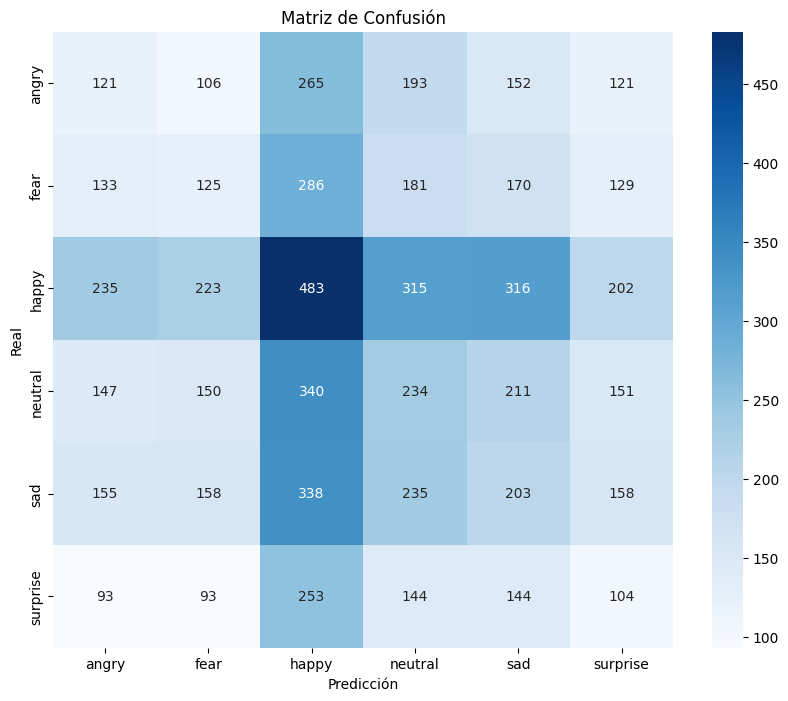

              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
        fear       0.15      0.12      0.13      1024
       happy       0.25      0.27      0.26      1774
     neutral       0.18      0.19      0.18      1233
         sad       0.17      0.16      0.17      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.18      7067
   macro avg       0.17      0.17      0.17      7067
weighted avg       0.18      0.18      0.18      7067



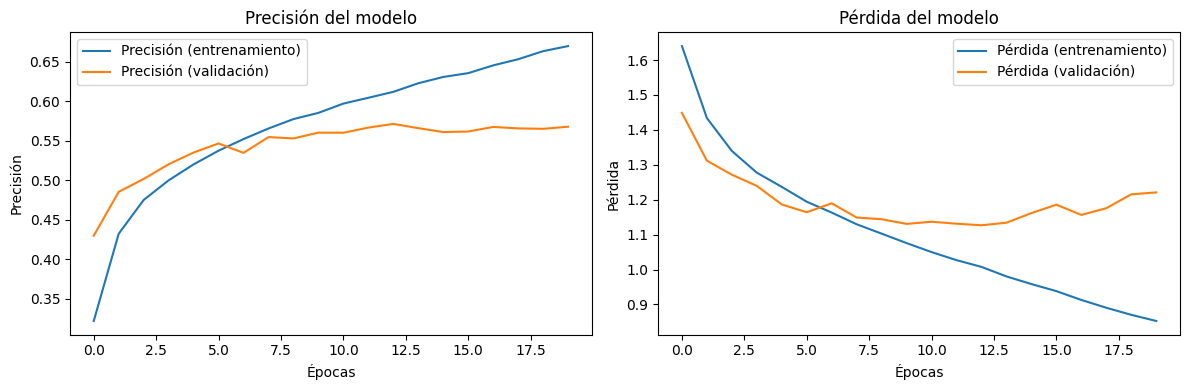

In [50]:
# Predicciones en el conjunto de prueba
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Obtener las etiquetas verdaderas
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Gráficos de rendimiento
plt.figure(figsize=(12, 4))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión (entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (validación)')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()